# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "./data/traffic-signs-data/train.p"
validation_file = "./data/traffic-signs-data/valid.p"
testing_file = "./data/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set

#### Extracting the class labels
The class labels in the dataset are integers, suitable for training. In order to provide more pleasant experience when analyzing the data in the next steps, I define a dictionary which will hold key-value pairs for each class label.

In [2]:
# Extracting all class labels for better clarity
import csv
class_labels_file = './data/signnames.csv'

with open(class_labels_file) as labels:
    fileReader = csv.reader(labels)
    class_labels = {int(item[0]):item[1] for item in fileReader}
    
print (class_labels)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

In [3]:
import numpy as np
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_validation)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
print("X_train shape is ", np.array(X_train).shape)
print("X_train element shape is ", np.array(X_train[0]).shape)
image_shape = np.array(X_train).shape[1:4]

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.array(y_train)).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

X_train shape is  (34799, 32, 32, 3)
X_train element shape is  (32, 32, 3)
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### An exploratory visualization of the dataset

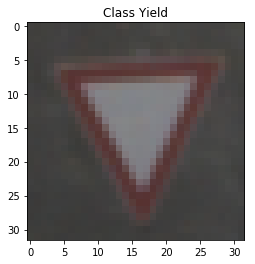

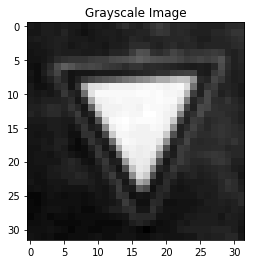

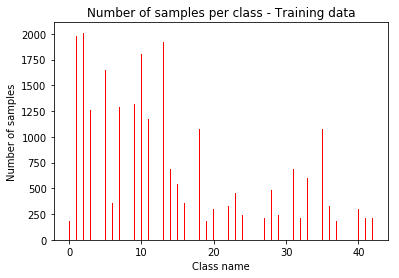

In [4]:
### Data exploration visualization code
import matplotlib.pyplot as plt
import cv2
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

# Plot a single image from the test dataset
index = random.randint(0, len(X_train))
plt.imshow(X_train[index])
plt.title("Class " + class_labels[y_train[index]])
plt.show()

modifiedImg = cv2.cvtColor(X_train[index], cv2.COLOR_RGB2GRAY)
plt.imshow(modifiedImg, cmap='gray')
plt.title("Grayscale Image")

# Plotting a bar chart of the number of samples per class included in the dataset
# Training set
indices = np.arange(0, n_classes)
bar_width = 0.1
fig, axis = plt.subplots()

classes, classes_count = np.unique(np.array(y_train), return_counts=True)

barchart = plt.bar(indices, tuple(classes_count), bar_width, color='r', label="Sample count (per class)")
plt.xlabel("Class name")
plt.ylabel("Number of samples")
plt.title("Number of samples per class - Training data")
plt.show()

----

## Step 2: Design and Test a Model Architecture

I Designed and implement a deep learning model that learns to recognize traffic signs. The model was trained and tested on Udacity's pickled subset of the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point (as suggested), so I started from there and played with it until the required results were met. 

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). _Udacity's tip_: It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. I use SKImage's functions to equalize the histogram of grayscaled images.

In [5]:
from sklearn.utils import shuffle

# Normalization functions
def normalize(dataset):
    dataset = np.array(dataset)
    print("Shape before normalization:", dataset.shape)
    dataset = (dataset - dataset.mean()) / dataset.std()
    print("Shape after normalization:", dataset.shape)
    return dataset

def grayscale(dataset):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in dataset])[:,:,:,np.newaxis]

def normalize_img(img):
    img = np.array(img)
    return (img - img.mean()) / img.std()

def grayscale_img(img):
    newimg = np.array(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return newimg

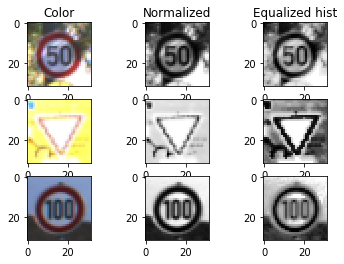

In [6]:
from skimage.exposure import equalize_hist
# http://blog.yhat.com/posts/image-processing-with-scikit-image.html_normalized_normalized

plt.figure()

for i in np.arange(0, 3):
    index = random.randint(0, len(X_train))
    plt.subplot(3,3,i*3+1)
    plt.imshow(X_train[index])
    if i == 0:
        plt.title("Color")
    plt.subplot(3,3,i*3+2)
    plt.imshow(normalize_img(grayscale_img(X_train[index])), cmap='gray')
    if i == 0:
        plt.title("Normalized")
    plt.subplot(3,3,i*3+3)
    plt.imshow(equalize_hist(grayscale_img(X_train[index])), cmap='gray')
    if i == 0:
        plt.title("Equalized hist")

In [7]:
def dataset_transform_for_CNN(dataset):
    dataset = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in dataset])
    return equalize_hist(dataset)[:,:,:,np.newaxis]

X_train_normalized = dataset_transform_for_CNN(X_train)

X_validation_normalized = dataset_transform_for_CNN(X_validation)
X_test_normalized = dataset_transform_for_CNN(X_test)

print("New image training set shape is", X_train_normalized.shape)

X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
print("Data preprocessing done.")

New image training set shape is (34799, 32, 32, 1)
Data preprocessing done.


### Model Architecture

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
### Using the model from LeNet lab in the CarND, modified for better results
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 25
BATCH_SIZE = 256 # 16394


def TrafficSignClassifier(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
# Training pipeline
### Using the model from LeNet lab in the CarND, modified for better results
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = TrafficSignClassifier(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
### Using the model from LeNet lab in the CarND, modified for better results

import time

start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        training_accuracy = evaluate(X_train_normalized, y_train)
        validation_accuracy = evaluate(X_validation_normalized, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic-sign-classifier-network')
    print("Model saved")
    
    print("It took ", time.time()-start_time, " seconds to train the network.")

Training...

EPOCH 1 ...
Training Accuracy = 0.299
Validation Accuracy = 0.289

EPOCH 2 ...
Training Accuracy = 0.617
Validation Accuracy = 0.594

EPOCH 3 ...
Training Accuracy = 0.761
Validation Accuracy = 0.734

EPOCH 4 ...
Training Accuracy = 0.839
Validation Accuracy = 0.800

EPOCH 5 ...
Training Accuracy = 0.866
Validation Accuracy = 0.822

EPOCH 6 ...
Training Accuracy = 0.903
Validation Accuracy = 0.852

EPOCH 7 ...
Training Accuracy = 0.920
Validation Accuracy = 0.873

EPOCH 8 ...
Training Accuracy = 0.931
Validation Accuracy = 0.889

EPOCH 9 ...
Training Accuracy = 0.938
Validation Accuracy = 0.903

EPOCH 10 ...
Training Accuracy = 0.945
Validation Accuracy = 0.907

EPOCH 11 ...
Training Accuracy = 0.953
Validation Accuracy = 0.906

EPOCH 12 ...
Training Accuracy = 0.959
Validation Accuracy = 0.918

EPOCH 13 ...
Training Accuracy = 0.960
Validation Accuracy = 0.917

EPOCH 14 ...
Training Accuracy = 0.966
Validation Accuracy = 0.925

EPOCH 15 ...
Training Accuracy = 0.969
Valid

---

## Step 3: Test a Model on New Images


### Load and Output the Images

5 downloaded images


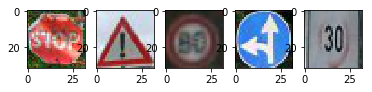

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
y_downloaded = [14, 18, 5, 37, 1]
downloaded_images = []
for i in np.arange(2, 7):
    img = cv2.imread("./data/downloaded-img-"+str(i)+".jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    downloaded_images.append(img)

    
print("5 downloaded images")
plt.figure()
for j in np.arange(1,6):
    plt.subplot(1,5,j)
    plt.imshow(downloaded_images[j-1])

### Predict the Sign Type for Each Image

(5, 32, 32, 1)
Downloaded image processing done.


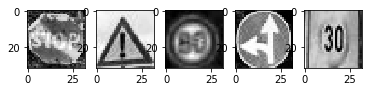

In [13]:
### Run the predictions here and use the model to output the prediction for each image.

X_downloaded = dataset_transform_for_CNN(downloaded_images)

plt.figure()
for j in np.arange(1,6):
    plt.subplot(1,5,j)
    plt.imshow(X_downloaded[j-1, :, :, 0], cmap='gray')
    
X_downloaded, y_downloaded = shuffle(X_downloaded, y_downloaded)
print(X_downloaded.shape)

print("Downloaded image processing done.")

### Analyze Performance

In [14]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./traffic-sign-classifier-network.meta')
    saver2.restore(sess, "./traffic-sign-classifier-network")
    
    test_imgs_accuracy = evaluate(X_test_normalized, np.array(y_test))
    print("Accuracy on the test set = {:.3f}".format(test_imgs_accuracy))
    downloaded_imgs_accuracy = evaluate(X_downloaded, np.array(y_downloaded))
    print("Accuracy on the downloaded set = {:.3f}".format(downloaded_imgs_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic-sign-classifier-network
Accuracy on the test set = 0.921
Accuracy on the downloaded set = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) proved helpful here. 

In [15]:
softmax_logits = tf.nn.softmax(logits)
top_5 = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./traffic-sign-classifier-network.meta')
    saver2.restore(sess, "./traffic-sign-classifier-network")

    predicted_logits = sess.run(softmax_logits, feed_dict={x: X_downloaded, keep_prob: 1.0})
    predicted_top_5 = sess.run(top_5, feed_dict={x: X_downloaded, keep_prob: 1.0})
    
    print(predicted_top_5)

INFO:tensorflow:Restoring parameters from ./traffic-sign-classifier-network
TopKV2(values=array([[  9.99316335e-01,   4.50107007e-04,   1.34511298e-04,
          9.79365432e-05,   7.46137744e-07],
       [  4.48494703e-01,   2.67958254e-01,   1.18599951e-01,
          8.65270048e-02,   3.42932083e-02],
       [  9.99986887e-01,   6.66770029e-06,   6.44829834e-06,
          1.85141902e-10,   1.00155745e-12],
       [  9.97121036e-01,   1.42622786e-03,   1.36747584e-03,
          8.52414305e-05,   4.77108797e-09],
       [  6.66880965e-01,   1.69982716e-01,   1.12141587e-01,
          2.68519390e-02,   2.26881728e-02]], dtype=float32), indices=array([[37, 40, 10, 33, 12],
       [ 5,  3,  6, 36, 32],
       [ 1,  2,  0, 31,  4],
       [18, 26, 27, 24, 29],
       [38, 17, 22, 26, 14]], dtype=int32))
